In [1]:
import sklearn
import pandas as pd
import numpy as np
import os
import re
import calendar

# set seed
np.random.seed(21)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# figure directories
PROJECT_ROOT_DIR = "./drive/MyDrive/UCL MSc"

In [69]:
import io
import nbformat
def nb_word_count(nb_path):
    with io.open(nb_path, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, nbformat.NO_CONVERT)
        word_count = 0
        for cell in nb.cells:
            if cell.cell_type == "markdown":
                word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    return word_count

In [86]:
nb_word_count('./drive/MyDrive/Colab Notebooks/MSIN0097 Individual Coursework.ipynb')

1997

# Objective

The [dataset](https://energydata.info/dataset/pakistan-solar-radiation-measurement-data) of interest is Pakistan Solar Radiation Measurements Data collated by the World Bank across 9 solar installation sites, each in a different city. 

Our objective is to build a predictive model capable of predicting solar irradiance levels based on atmospheric measurements, date and time. 

Installing solar irradiation sensors like thermopyranometers are expensive. However, atmospheric measurements like wind speed, humidity, pressure are cheap to make. By accurately predicting solar irradiation from cheap measurements, we can identify new sites for solar panel installation at a lower cost. 

# Loading the data

In [2]:
# load csv file
df = pd.read_csv(os.path.join(PROJECT_ROOT_DIR, 'pakistan_solar_measurements.csv'))

# Column 14 is the comments column, of mixed type but we are not using it as a feature, so we ignore the warning

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We obtain additional elevation, latitude and longitude for each site from a separate json file.

In [3]:
import json

# load and parse json file
with open(os.path.join(PROJECT_ROOT_DIR, 'globalsolar.json')) as f:
  j = json.load(f)

# create empty dictionaries, will store city name as keys and respective values
elevations, latitudes, longitudes = dict(), dict(), dict()

for i in j['features']:
  if i['properties']['Country'] != 'Pakistan': # skip non-Pakistan data in this file
    continue
  else:
    # set values for each city in each dictionary
    city = i['properties']['Nearest Settlement'].lower()
    elevations[city] = i['properties']['Elevation']
    latitudes[city] = i['properties']['Latitude']
    longitudes[city] = i['properties']['Longitude']

In [4]:
# use dictionaries and map method to create new columns
df['elevation'] = df['city'].map(elevations)
df['latitude'] = df['city'].map(latitudes)
df['longitude'] = df['city'].map(longitudes)

# check that mapping was done correctly
df.loc[np.random.randint(0, len(df), 20), ['city','elevation','latitude','longitude']]

,city,elevation,latitude,longitude
605129,lahore,220,31.69458,74.24410
857295,peshawar,370,34.00170,71.48540
202552,hyderabad,60,25.41340,68.25950
664324,lahore,220,31.69458,74.24410
81968,bahawalpur,120,29.32542,71.81877
63856,bahawalpur,120,29.32542,71.81877
566392,lahore,220,31.69458,74.24410
785827,multan,95,30.16540,71.49780
481980,khuzdar,1260,27.81780,66.62940
701026,multan,95,30.16540,71.49780


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022196 entries, 0 to 1022195
Data columns (total 18 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   city                        1022196 non-null  object 
 1   time                        1022196 non-null  object 
 2   ghi_pyr                     1009785 non-null  float64
 3   ghi_rsi                     753656 non-null   float64
 4   dni                         981159 non-null   float64
 5   dhi                         981159 non-null   float64
 6   air_temperature             1009784 non-null  float64
 7   relative_humidity           1009784 non-null  float64
 8   wind_speed                  1009784 non-null  float64
 9   wind_speed_of_gust          1009784 non-null  float64
 10  wind_from_direction_st_dev  1009784 non-null  float64
 11  wind_from_direction         1009784 non-null  float64
 12  barometric_pressure         1009784 non-null  float64
 1

## Data Dictionary

| time                       | Date and time according to ISO8601 (yyyy-mm-dd HH:MM)                     |
|----------------------------|---------------------------------------------------------------------------|
| ghi_pyr                    | Global horizontal irradiance (W/m²) from thermopile pyranometer           |
| ghi_rsi                    | Global horizontal irradiance (W/m²) from Rotating Shadowband Irradiometer |
| dni                        | Direct normal irradiance (W/m²) from thermopile pyrheliometer             |
| dhi                        | Diffused horizontal irradiance (W/m²) from thermopile pyranometer         |
| air_temperature            | Air temperature (°C) at 2 m height                                        |
| relative_humidity          | Relative humidity (%) at 2 m height                                       |
| wind_speed                 | Wind speed (m/s) at 10 m height                                           |
| wind_speed_of_gust         | Maximum wind speed in the integration interval                            |
| wind_from_direction        | Wind direction in degrees north, counted clockwise                        |
| wind_from_direction_st_dev | Wind direction in degrees north, counted clockwise (standard deviation)   |
| barometric_pressure        | Ambient air pressure in hPa                                               |
| sensor_cleaning            | 1 (yes) / 0 (no)                                                          |
| elevation            | Metres above sea level                                                          |
| latitude            | Positive north, decimal degrees                                                          |
| longitude            | Positive east, decimal degrees                                                          |

# Data Cleaning and Feature Engineering

In [6]:
# drop rows with missing features and targets
drop_cols = ['ghi_pyr', 'time','air_temperature','relative_humidity','wind_speed','wind_speed_of_gust','wind_from_direction_st_dev','wind_from_direction','barometric_pressure','elevation','latitude','longitude']

df = df.dropna(subset=drop_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009784 entries, 0 to 1022195
Data columns (total 18 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   city                        1009784 non-null  object 
 1   time                        1009784 non-null  object 
 2   ghi_pyr                     1009784 non-null  float64
 3   ghi_rsi                     753655 non-null   float64
 4   dni                         981158 non-null   float64
 5   dhi                         981158 non-null   float64
 6   air_temperature             1009784 non-null  float64
 7   relative_humidity           1009784 non-null  float64
 8   wind_speed                  1009784 non-null  float64
 9   wind_speed_of_gust          1009784 non-null  float64
 10  wind_from_direction_st_dev  1009784 non-null  float64
 11  wind_from_direction         1009784 non-null  float64
 12  barometric_pressure         1009784 non-null  float64
 1

In [7]:
# convert time column to datetime dtype and sort in ascending order
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by='time')

We create features from datetime to allow seasonality and exact time variations to be captured.

In [8]:
# New features for month, day, day of year, hour, minute and minute of day
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['dayofyear'] = df['time'].dt.dayofyear
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df['minofday'] = df['hour'] * 60 + df['minute']

Since our objective to predict solar irradiance for new solar installation sites, we drop two features from training - *city* and *sensor_cleaning*. These features are unavailable for new sites. 

We also remove rows corresponding to the irradiation measurements when the sun has already set, i.e. irradiance = 0. These rows are noise and may hurt model performance, because we intend to only make predictions for solar irradiation during daylight hours. 



In [9]:
# filter desired rows and columns
keep_cols = ['ghi_pyr','month','day','dayofyear','hour','minute','minofday','air_temperature','relative_humidity','wind_speed','wind_speed_of_gust','wind_from_direction_st_dev','wind_from_direction','barometric_pressure','elevation','latitude','longitude']
daylight_filter = df['ghi_pyr'] > 0

df = df.loc[daylight_filter, keep_cols]

# Exploratory Data Analysis

We perform visualizations on the training dataset only, to prevent leakage of information from the test set subconsciously influencing our modelling decisions.

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(labels=['ghi_pyr'], axis=1)
y = df['ghi_pyr']

# stratify across elevation (1-1 correspondence with city)
# so that measurements from each city are properly distributed across test and training split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=df['elevation']) 

In [11]:
viz = pd.concat([X_train, y_train], axis=1)
viz.shape

(355566, 17)

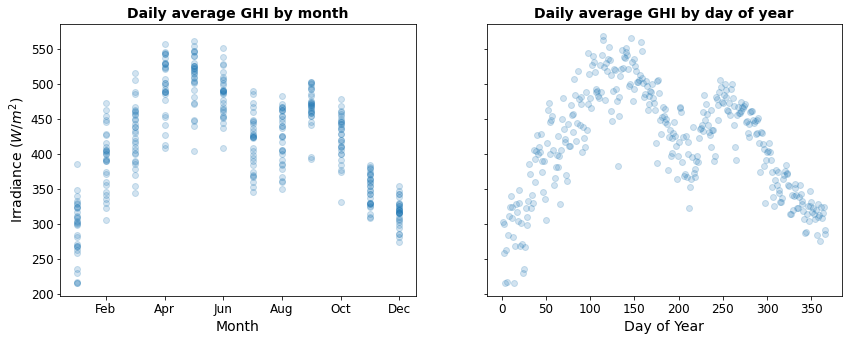

In [12]:
# figure initialization
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14, 5))

# group data for visualization by month
by_mth_day = viz.groupby(['month','day'])['ghi_pyr'].mean().reset_index()
# plotting calls
axs[0].scatter(by_mth_day['month'], by_mth_day['ghi_pyr'], alpha=0.2)
axs[0].set_xticklabels([calendar.month_abbr[mth] for mth in range(0, 13, 2)])
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Irradiance $(W/m^2)$')
axs[0].set_title('Daily average GHI by month', fontdict={'size':14, 'weight':'semibold'})

# group data for visualization by day of year
by_dayofyear = viz.groupby(['dayofyear'])['ghi_pyr'].mean().reset_index()
# plotting calls
axs[1].scatter(by_dayofyear['dayofyear'], by_dayofyear['ghi_pyr'], alpha=0.2)
axs[1].set_xlabel('Day of Year')
axs[1].set_title('Daily average GHI by day of year', fontdict={'size':14, 'weight':'semibold'})

plt.show()

**Insights**
 - Within any single day or month, there is variation in irradiation, likely due to atmospheric variations
 - Seasonality, winter months experiencing lower solar intensity compared to summer months 


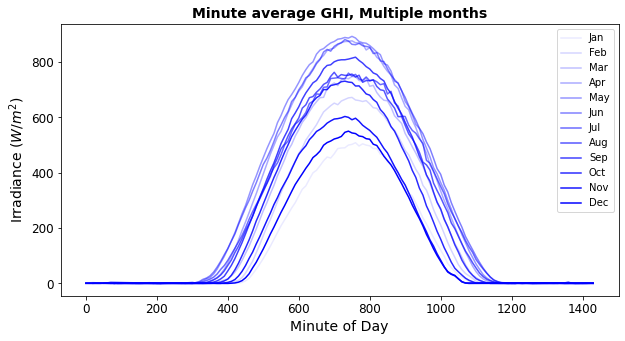

In [13]:
# figure initialization
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# group data by minute of day for visualization
by_minofday = viz.groupby(['minofday', 'month'])['ghi_pyr'].mean().reset_index()

# plotting calls
axs.set_xlabel('Minute of Day')
axs.set_ylabel('Irradiance $(W/m^2)$')
axs.set_title('Minute average GHI, Multiple months', fontdict={'size':14, 'weight':'semibold'})
for mth in sorted(by_minofday['month'].unique()): # one line plot for each month 
  axs.plot(by_minofday.loc[by_minofday['month'] == mth, 'minofday'], by_minofday.loc[by_minofday['month'] == mth, 'ghi_pyr'], 'b-', alpha=mth/12, label=calendar.month_abbr[mth])

plt.legend(loc='best')
plt.show()

**Insights**
 - Irradiance is highest around noon, but the peak is slightly right shifted for summer months compared to winter months.
 - As expected, sunrises later and sets earlier in winter months.
 - The maximal irradiance is higher in summer, the highest summer peak is almost twice that of the lowest winter peak. 
 - Geater jaggedness of the curves in summer months. Summer irradiance might have greater variance in or with atmospheric conditions.

For a specific time of day, we can see variations that correlate with atmospheric conditions. 

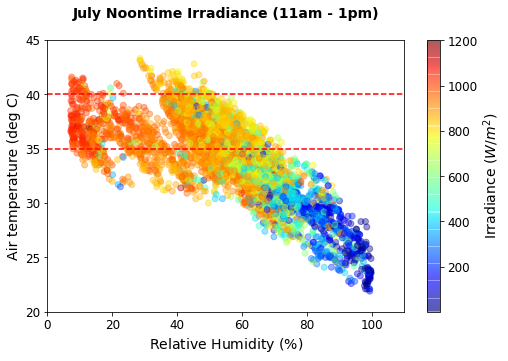

In [39]:
# slice dataset for july noontime
noontime = viz.loc[(viz['hour'] >= 11) & (viz['hour'] <= 13) & (viz['month']==7), :]

# plotting calls
plt.figure(figsize=(8,5))
plt.scatter(noontime['relative_humidity'], noontime['air_temperature'], c=noontime['ghi_pyr'], alpha=0.4, cmap=plt.cm.jet)
plt.plot((0,110),(35,35), 'r--')
plt.plot((0,110),(40,40), 'r--')

# formatting
plt.axis([0,110,20,45])
plt.xlabel('Relative Humidity $(\%)$')
plt.ylabel('Air temperature (deg C)')
plt.colorbar(label='Irradiance $(W/m^2)$', alpha=1)
plt.title('July Noontime Irradiance (11am - 1pm)\n', fontdict={'size':14, 'weight':'semibold'})
plt.show()

**Insights**
 - Air temperature and humidity are negatively correlated.
 - Jointly, they explain the variation in irradiance. Within the red band of high temperatures, increasing humidity is accompanied by lower irradiation. 

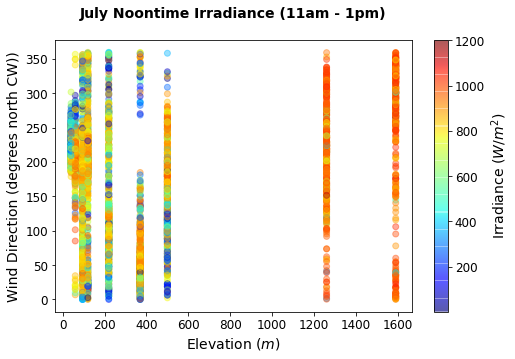

In [40]:
# plotting calls
plt.figure(figsize=(8,5))
plt.scatter(noontime['elevation'], noontime['wind_from_direction'], c=noontime['ghi_pyr'], alpha=0.4, cmap=plt.cm.jet)

# formatting
plt.xlabel('Elevation $(m)$')
plt.ylabel('Wind Direction (degrees north CW))')
plt.colorbar(label='Irradiance $(W/m^2)$', alpha=1)
plt.title('July Noontime Irradiance (11am - 1pm)\n', fontdict={'size':14, 'weight':'semibold'})
plt.show()

**Insights**
 - Higher elevations receive more intense irradiation.
 - Note that each elevation value is associated with a different measurement site (city).
 - In the lower elevations, there is much greater variation in irradiance with wind direction.  
 - Dataset has a noticeably large gap in elevations (about 500 to 1200); for new sites within such an elevation range, our predictive model might not perform well.  

To summarize any linear relationships, we plot a heatmap:

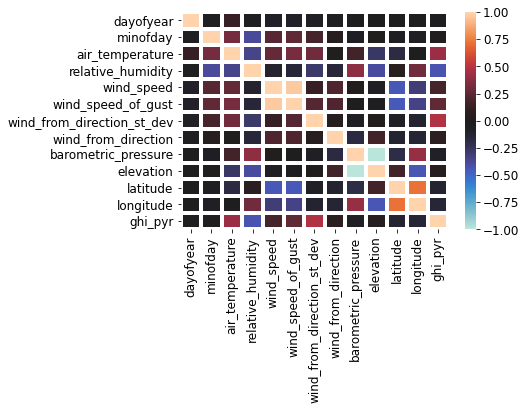

In [16]:
import seaborn as sns

cols = ['dayofyear','minofday','air_temperature','relative_humidity','wind_speed','wind_speed_of_gust','wind_from_direction_st_dev','wind_from_direction','barometric_pressure','elevation','latitude','longitude','ghi_pyr']
sns.heatmap(viz.loc[:, cols].corr(), linewidths=3, vmin=-1, vmax=1, center=0)

plt.show()

**Insights**
 -  *air_temperature*, *relative_humidity*, *wind_speed* variables have some linear relationships with irradiance (*ghi_pyr*). 
 - Time-related variables are dark (correlation close to 0), because their relationship is non-linear with irradiance (as visualized earlier).

# Training models

## Linear Regressor

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_train)
lr_rmse = np.sqrt(mean_squared_error(y_pred_lr, y_train))

print('rmse:', lr_rmse)

lr_scores = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print('cross validated rmse:', np.sqrt(np.mean(-lr_scores)))

rmse: 211.50482366259547
cross validated rmse: 211.53584182178625


## Linear SVR

In [ ]:
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler

std_scaler_x = StandardScaler()

X_std = std_scaler_x.fit_transform(X_train)

lsvr_reg = LinearSVR(epsilon=100, C=50)
lsvr_reg.fit(X_std, y_train)

y_pred_svr = lsvr_reg.predict(X_std)
lsvr_rmse = np.sqrt(mean_squared_error(y_pred_svr, y_train))

print('rmse:', lsvr_rmse)

lsvr_scores = cross_val_score(lsvr_reg, X_std, y_train, scoring='neg_mean_squared_error', cv=5)
print('cross validated rmse:', np.sqrt(np.mean(-lsvr_scores)))

rmse: 212.50018206230953
cross validated rmse: 212.53178991398863


The Linear SVR does not perform any better than the Linear Regression model. The high MSE of such linear models on both training and validation set is indicative of a *high bias*. Linear models likely cannot capture the relationship between *ghi_pyr* and the other features. 

## Lasso Regressor with polynomial features

We next try regression on a polynomial featureset, with interaction and quadratic terms. Our earlier visualizations suggested the presence of some interaction between features.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

std_scaler_x = StandardScaler()
std_scaler_y = StandardScaler()
polyfeat = PolynomialFeatures(degree=2)

X_poly = std_scaler_x.fit_transform(polyfeat.fit_transform(X_train))

poly_lasso = Lasso(alpha=0.3, tol=0.1)
poly_lasso.fit(X_poly, y_train)

y_pred_poly = poly_lasso.predict(X_poly)
poly_lasso_rmse = np.sqrt(mean_squared_error(y_pred_poly, y_train))
print('rmse:', poly_lasso_rmse)

poly_lasso_scores = cross_val_score(poly_lasso, X_poly, y_train, scoring='neg_mean_squared_error', cv=5)
print('cross validated rmse:', np.sqrt(np.mean(-poly_lasso_scores)))

rmse: 137.0840468853998
cross validated rmse: 137.01731653010813


Adding polynomial features and allowing for $l1$ regularization results in a significantly lower RMSE compared to the linear models. Both training and validation RMSE are close and still quite high, suggesting that the polynomial representation is not rich enough.

## SVR Regressor with Bagging

Next, we explore an SVR regressor with non-linear kernels. However, with more than 300,000 instances in our training data, the SVR algorithm will take an impractically long time.  

We rely on the Nystroem kernel approximation method to approximate the RBF features, and use a LinearSVR for faster tranining.

In [ ]:
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
import time

rbf_approx = Pipeline([
                       ('std_scaler', StandardScaler()),
                       ('nystroem', Nystroem(kernel='rbf', gamma=0.25, n_components=500)),
                       ('linear_svr', LinearSVR(epsilon=0, C=1)),
                      ])


start_time = time.time()
rbf_approx.fit(X_train, y_train)
end_time = time.time()
print('training time:', round(end_time - start_time, 0), 'seconds')

y_pred_rbf_approx = rbf_approx.predict(X_train)
lsvr_rbf_approx_rmse = np.sqrt(mean_squared_error(y_pred_rbf_approx, y_train))
print('rmse:', lsvr_rbf_approx_rmse)

lsvr_rbf_approx_scores = cross_val_score(rbf_approx, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print('cross validated rmse:', np.sqrt(np.mean(-lsvr_rbf_approx_scores)))

training time: 20.0 seconds
rmse: 155.89945216759372
cross validated rmse: 156.1627295812309


The RBF kernel approximation Linear SVR has a similar RMSE with the polynomial lasso regressor. This is expected - in higher dimensions, the Gaussian RBF and polynomial kernels do not yield very different results. 

## Random Forest Regressor

Ensemble methods might perform better than single models. We fit a Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rnd_forest = RandomForestRegressor(n_estimators=30, min_samples_split=50, min_samples_leaf=10, max_samples=0.8, oob_score=True)
rnd_forest.fit(X_train, y_train)

print('oob score:', rnd_forest.oob_score_)
print('oob rmse:', np.sqrt((1 - rnd_forest.oob_score_) * np.var(y_train))) # SSE = (1 - R^2) * SST, divide by n to get MSE; and SST / n = variance

y_pred_rf = rnd_forest.predict(X_train)
rf_rmse = np.sqrt(mean_squared_error(y_pred_rf, y_train))
print('training rmse:', rf_rmse)

oob score: 0.9211503574188211
oob rmse: 82.33151720776635
training rmse: 72.87347175665158


The random forest regressor performs very well, with an out-of-bag $R^2$ of 0.92, equivalent to an RMSE of approximately 82. 

Evaluate both Gini and permutation feature importance:

In [ ]:
from sklearn.inspection import permutation_importance
# Obtain permutation importance
results = permutation_importance(rnd_forest, X_train, y_train, n_repeats=10, random_state=21)

feat_imp_rf1 = pd.DataFrame({'variable':X.columns,'value': results['importances_mean']}).sort_values(by='value', ascending=True)
feat_imp_rf2 = pd.DataFrame({'variable':X.columns,'value': rnd_forest.feature_importances_}).sort_values(by='value', ascending=True)

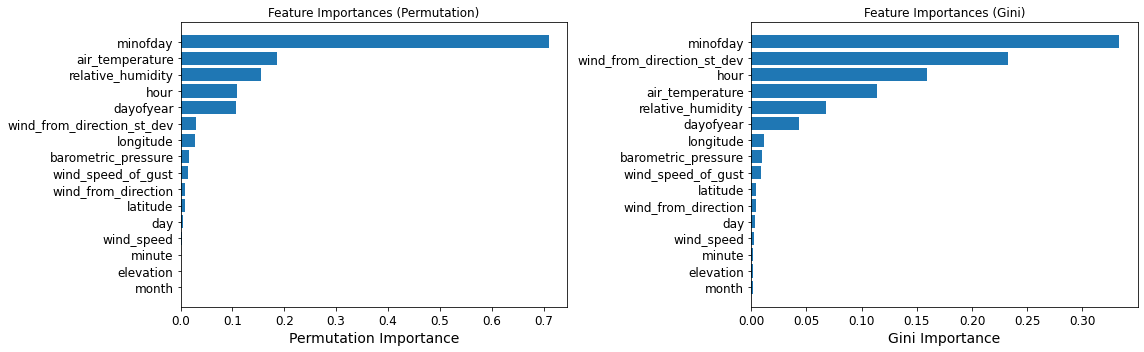

In [ ]:
# Figure initialization
fig, axs = plt.subplots(1,2, figsize=(16, 5))

# Plot first bar chart for permutation importance
axs[0].barh(feat_imp_rf1['variable'], width=feat_imp_rf1['value'])
axs[0].set_xlabel('Permutation Importance')
axs[0].set_title('Feature Importances (Permutation)')

# Plot second bar chart for Gini importance
axs[1].barh(feat_imp_rf2['variable'], width=feat_imp_rf2['value'])
axs[1].set_xlabel('Gini Importance')
axs[1].set_title('Feature Importances (Gini)')

plt.tight_layout()
plt.show()

**Insights**
 - *minofday* is the most important feature by both evaluations.
 - *wind_from_direction_st_dev* has low permutation importance; its high Gini importance is likely due to its high cardinality. Likewise for *hour*.
 - Overall, top 3 most predictive features would be *minofday*, *air_temperature*, and *relative_humidity*.

### Hyperparameter Tuning for Random Forest Regressor

Explore the hyperparameter space using random search to start:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# distribution of parameters to search in
distrib_1 = {
    'n_estimators': randint(low=30, high=80),
    'max_depth': randint(low=2, high=20),
    'min_samples_split': randint(low=20, high=50),
    'min_samples_leaf': randint(low=5, high=20),
    'max_samples': uniform(loc=0.4, scale=0.6)
    }

rf1 = RandomForestRegressor()
rcv_1 = RandomizedSearchCV(rf1, distrib_1, n_iter=10)
rf_search_1 = rcv_1.fit(X_train, y_train)

In [ ]:
print('best params:', rf_search_1.best_params_)
print('best score:', rf_search_1.best_score_)

best params: {'max_depth': 19, 'max_samples': 0.7994010356849877, 'min_samples_leaf': 11, 'min_samples_split': 25, 'n_estimators': 41}
best score: 0.922188420771309


In [ ]:
rf1_df = pd.DataFrame(rf_search_1.cv_results_)
rf1_df.loc[:, ['rank_test_score','mean_test_score','std_test_score','param_max_depth','param_max_samples','param_min_samples_leaf','param_min_samples_split','param_n_estimators']].sort_values(by='rank_test_score')

,rank_test_score,mean_test_score,std_test_score,param_max_depth,param_max_samples,param_min_samples_leaf,param_min_samples_split,param_n_estimators
9,1,0.922188,0.000625,19,0.799401,11,25,41
6,2,0.919879,0.000633,18,0.815149,7,38,44
2,3,0.915271,0.000536,16,0.441982,6,24,30
0,4,0.913341,0.000553,15,0.959127,8,30,39
4,5,0.908887,0.000609,14,0.882823,12,31,69
7,6,0.842915,0.001823,8,0.851911,17,25,42
5,7,0.821042,0.001518,7,0.490511,8,22,48
1,8,0.787372,0.001783,6,0.889618,7,29,30
3,9,0.747798,0.002159,5,0.902324,5,44,65
8,10,0.587084,0.000432,3,0.796446,15,34,72


**Insights**
 - Deeper trees perform better
 - Number of estimators and proportion sampled does not affect the performance 
 - Effects of mininum samples for splitting and in each leaf are ambiguous 
 

Second random search, with a narrowed range for parameters that affect performance:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# narrower distribution from first search, closer to best params found above
distrib_2 = {
    'max_depth': randint(low=18, high=30),
    'min_samples_split': randint(low=25, high=35),
    'min_samples_leaf': randint(low=5, high=15),
    }

rf2 = RandomForestRegressor(n_estimators=30, max_samples=0.8) # fix hyperparamaters with little impact on performance
rcv_2 = RandomizedSearchCV(rf2, distrib_2, n_iter=10)
rf_search_2 = rcv_2.fit(X_train, y_train)

In [ ]:
print('best params:', rf_search_2.best_params_)
print('best score:', rf_search_2.best_score_)

best params: {'max_depth': 29, 'min_samples_leaf': 6, 'min_samples_split': 27}
best score: 0.9252218225767954


In [ ]:
rf2_df = pd.DataFrame(rf_search_2.cv_results_)
rf2_df.loc[:, ['rank_test_score','mean_test_score','std_test_score','param_max_depth','param_min_samples_leaf','param_min_samples_split']].sort_values(by='rank_test_score')

,rank_test_score,mean_test_score,std_test_score,param_max_depth,param_min_samples_leaf,param_min_samples_split
9,1,0.925222,0.000524,29,6,27
3,2,0.923501,0.000615,22,6,33
0,3,0.923150,0.000624,29,9,32
5,4,0.923131,0.000527,21,10,27
8,5,0.923044,0.000448,25,8,33
4,6,0.922832,0.000576,26,11,30
6,7,0.922421,0.000575,29,11,32
1,8,0.922021,0.000665,29,13,31
2,9,0.921218,0.000475,18,8,26
7,10,0.920646,0.000502,18,8,30


**Insights**
 - All 10 models have very similar scores, with $R^2 \approx 0.92$ 
 - No significant difference above 20+ max_depth
 - No significant difference between 27 or 33 min_samples_split
 - 6 seems to be a good choice for min_samples_leaf

Refined search using GridSearchCV:

In [ ]:
from sklearn.model_selection import GridSearchCV

# grid search to explore higher depths
distrib_3 = {
    'max_depth': [28, 30, 32, 34, 36],
    }

# fix the parameters we are confident about
rf3 = RandomForestRegressor(n_estimators=30, min_samples_leaf=6, min_samples_split=30, max_samples=0.8)
rcv_3 = GridSearchCV(rf3, distrib_3)
rf_search_3 = rcv_3.fit(X_train, y_train)

In [ ]:
rf3_df = pd.DataFrame(rf_search_3.cv_results_)
rf3_df.loc[:, ['rank_test_score','mean_test_score','std_test_score','param_max_depth']].sort_values(by='rank_test_score')

,rank_test_score,mean_test_score,std_test_score,param_max_depth
3,1,0.924592,0.000540,34
2,2,0.924549,0.000496,32
4,3,0.924525,0.000642,36
1,4,0.924486,0.000551,30
0,5,0.924479,0.000403,28


There is no meaningful difference in scores for these high *max_depth* values. Using the best parameters, the model performs as expected on the test set. 

In [42]:
from sklearn.ensemble import RandomForestRegressor

rnd_forest_best = RandomForestRegressor(max_depth=34, n_estimators=30, min_samples_split=30, min_samples_leaf=6, max_samples=0.8, oob_score=True)
rnd_forest_best.fit(X_train, y_train)

y_pred_rf_best = rnd_forest_best.predict(X_test)
rf_best_rmse = np.sqrt(mean_squared_error(y_pred_rf_best, y_test))
print('test rmse:', rf_best_rmse)

oob score: 0.92591032642441
oob rmse: 79.80775511116063
test rmse: 78.84182292300694


## Gradient Boosted Regression Tree

We explore fitting a gradient boosted regression tree:

In [17]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Create a holdout set from the training data to implement early stopping
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X_train)
X_std_train, X_std_val, y_train_small, y_train_val = train_test_split(X_std, y_train, test_size=0.2)

# Convert training data into DMatrix
X_std_train = xgb.DMatrix(X_std_train, label=y_train_small)
X_std_val = xgb.DMatrix(X_std_val, label=y_train_val)

# set hyperparameters
params =  {'max_depth':15, 'eta':0.3, 'gamma':5, 'min_child_weight':4, 'colsample_bytree':0.9, 'colsample_bylevel':0.9, 'objective': 'reg:squarederror', 'seed':21}

# dict to store errors during training iterations for watchlist datasets
xgb_errors = dict()
watchlist = [(X_std_train, 'train'), (X_std_val, 'eval')]

# train model
xgb_model = xgb.train(params, X_std_train, num_boost_round=500, early_stopping_rounds=10, evals=watchlist, evals_result=xgb_errors, verbose_eval=10)

# xgb_model = xgb.XGBRegressor(**param)
# xgb_model.fit(X_std_train, y_train_small, eval_set=[(X_std_val, y_train_val)], early_stopping_rounds=10)

[0]	train-rmse:363.219	eval-rmse:363.846
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[10]	train-rmse:56.2879	eval-rmse:76.6812
[20]	train-rmse:41.7019	eval-rmse:70.9288
[30]	train-rmse:34.2644	eval-rmse:68.947
[40]	train-rmse:30.1029	eval-rmse:68.4386
[50]	train-rmse:26.0009	eval-rmse:67.7462
[60]	train-rmse:23.5149	eval-rmse:67.548
[70]	train-rmse:20.81	eval-rmse:67.3227
[80]	train-rmse:19.3893	eval-rmse:67.2039
[90]	train-rmse:17.2926	eval-rmse:67.0378
[100]	train-rmse:16.0901	eval-rmse:66.9412
[110]	train-rmse:14.3305	eval-rmse:66.875
[120]	train-rmse:13.1656	eval-rmse:66.8243
[130]	train-rmse:12.2961	eval-rmse:66.8014
[140]	train-rmse:11.1341	eval-rmse:66.7546
[150]	train-rmse:10.3611	eval-rmse:66.7125
[160]	train-rmse:9.52747	eval-rmse:66.6982
[170]	train-rmse:8.84572	eval-rmse:66.687
[180]	train-rmse:8.06515	eval-rmse:66.6238
[190]	train-rmse:7.43994	eval-rmse:66.5951
[200]	train-rm

The gradient boosted tree has the best performance so far, with validation set RMSE of around 66 compared to 80 for the random forest regressor.  

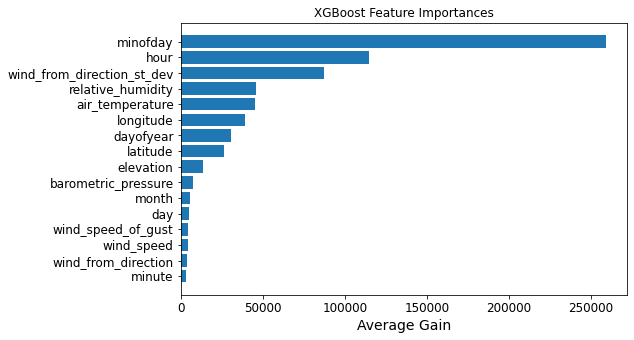

In [41]:
# create feature map file
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

create_feature_map(X.columns)

# impute feature importances into fmap file
importances = xgb_model.get_score(fmap='xgb.fmap', importance_type='gain')

# create df and visualize
feat_imp_xgb = pd.DataFrame.from_dict(importances, orient='index', columns=['value']).sort_values(by='value', ascending=True)
plt.figure(figsize=(8, 5))
plt.barh(feat_imp_xgb.index, width=feat_imp_xgb['value'])
plt.xlabel('Average Gain')
plt.title('XGBoost Feature Importances')
plt.show()

**Insights**
 - Top predictive features are identical with the Random Forest Regressor


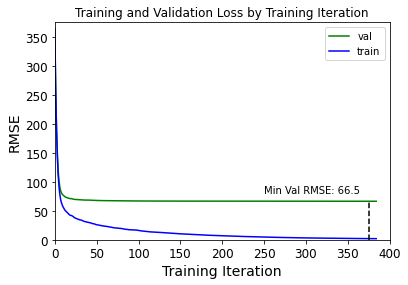

In [22]:
plt.plot(np.arange(0, len(xgb_errors['eval']['rmse'])), xgb_errors['eval']['rmse'], 'g-', label='val')
plt.plot(np.arange(0, len(xgb_errors['eval']['rmse'])), xgb_errors['train']['rmse'], 'b-', label='train')
plt.plot((375, 375), (0, 67.7762), 'k--')
plt.axis((0, 400, 0, 375))
plt.annotate('Min Val RMSE: 66.5', (375, 66.5), xytext=(250, 80))
plt.xlabel('Training Iteration')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.title('Training and Validation Loss by Training Iteration')
plt.show()

**Insight**
 - Learning plateaus by the 20th iteration

### Hyperparameter tuning for XGBoost Model


In [25]:
# initialize grid of parameters to search, best params and score variables
gridsearch_params_xgb = [
                         (depth, child, eta, gamma) 
                         for depth in [15, 20] 
                         for child in [5, 10] 
                         for eta in [0.2, 0.25, 0.3, 0.35] 
                         for gamma in [5, 10]
                         ]
min_rmse = float("Inf")
best_params = None

# Convert training set to DMatrix
dtrain = xgb.DMatrix(X_std, label=y_train)

# Standard parameters that we are not searching
params =  {'colsample_bytree':0.9, 'colsample_bylevel':0.9, 'objective': 'reg:squarederror'}

for max_depth, min_child_weight, eta, gamma in gridsearch_params_xgb:
    print(f'CV with max_depth={max_depth}, min_child_weight={min_child_weight}, eta={eta}, gamma={gamma}')

    # Set parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    params['eta'] = eta
    params['gamma'] = gamma

    # Run cross-validation with maximum 50 rounds to reduce training time
    # Will not negatively affect estimates of the best RMSE as the learning plateaus as early as the 20th iteration (see graph)
    cv_results = xgb.cv(params, dtrain, seed=21, nfold=5, metrics={'rmse'}, early_stopping_rounds=10, num_boost_round=50)

    # Update best RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin() + 1
    print(f'\tAchieved RMSE of {mean_rmse} in {boost_rounds}th round')
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, min_child_weight, eta, gamma)

# After testing all combinations, print out best parameters
print(f'Best params - Depth:{best_params[0]}, Min Child:{best_params[1]}, eta:{best_params[2]}, gamma:{best_params[3]} -->> RMSE: {min_rmse}')

CV with max_depth=15, min_child_weight=5, eta=0.2, gamma=5
	 Achieved RMSE of 67.992714 in 50th round
CV with max_depth=15, min_child_weight=5, eta=0.2, gamma=10
	 Achieved RMSE of 67.66137060000001 in 50th round
CV with max_depth=15, min_child_weight=5, eta=0.25, gamma=5
	 Achieved RMSE of 68.3794234 in 50th round
CV with max_depth=15, min_child_weight=5, eta=0.25, gamma=10
	 Achieved RMSE of 68.3807206 in 50th round
CV with max_depth=15, min_child_weight=5, eta=0.3, gamma=5
	 Achieved RMSE of 69.007277 in 50th round
CV with max_depth=15, min_child_weight=5, eta=0.3, gamma=10
	 Achieved RMSE of 69.2135466 in 50th round
CV with max_depth=15, min_child_weight=5, eta=0.35, gamma=5
	 Achieved RMSE of 70.228331 in 50th round
CV with max_depth=15, min_child_weight=5, eta=0.35, gamma=10
	 Achieved RMSE of 70.232123 in 50th round
CV with max_depth=15, min_child_weight=10, eta=0.2, gamma=5
	 Achieved RMSE of 68.30680720000001 in 50th round
CV with max_depth=15, min_child_weight=10, eta=0.2, ga

Performing grid search with cross-validation across different parameter combinations, we see very similar values of RMSE.
 - Similar cross-validation results imply that the flat learning is not due to  perculiarities of our training dataset.
 - The changes in the parameters only have a small effect on RMSE.  

Train the final XGBoost model with best parameters subject to early stopping:

In [27]:
# set hyperparameters
params =  {'max_depth':20, 'eta':0.2, 'gamma':10, 'min_child_weight':10, 'colsample_bytree':0.9, 'colsample_bylevel':0.9, 'objective': 'reg:squarederror', 'seed':21}

# dict to store errors during training iterations for watchlist datasets
xgb_best_errors = dict()
watchlist = [(X_std_train, 'train'), (X_std_val, 'eval')]

# train model
xgb_best_model = xgb.train(params, X_std_train, num_boost_round=500, early_stopping_rounds=10, evals=watchlist, evals_result=xgb_best_errors, verbose_eval=25)

[0]	train-rmse:411.694	eval-rmse:412.004
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[25]	train-rmse:33.1082	eval-rmse:67.3009
[50]	train-rmse:24.0853	eval-rmse:65.5689
[75]	train-rmse:19.8195	eval-rmse:64.9988
[100]	train-rmse:16.0544	eval-rmse:64.7105
[125]	train-rmse:13.1975	eval-rmse:64.5329
[150]	train-rmse:10.3029	eval-rmse:64.3585
[175]	train-rmse:8.40178	eval-rmse:64.283
[200]	train-rmse:7.17732	eval-rmse:64.2363
[225]	train-rmse:5.91366	eval-rmse:64.2038
[250]	train-rmse:5.09134	eval-rmse:64.1758
[275]	train-rmse:4.08087	eval-rmse:64.1505
[300]	train-rmse:3.3924	eval-rmse:64.128
[325]	train-rmse:2.70965	eval-rmse:64.1114
[350]	train-rmse:2.18419	eval-rmse:64.0968
[375]	train-rmse:1.91679	eval-rmse:64.0885
[400]	train-rmse:1.73512	eval-rmse:64.0861
Stopping. Best iteration:
[394]	train-rmse:1.77263	eval-rmse:64.086



In [31]:
# Use model to predict irradiance from test set
X_std_test = xgb.DMatrix(std_scaler.transform(X_test))
y_pred_xgb = xgb_best_model.predict(X_std_test)

# Evaluate RMSE on test set
xgb_test_rmse = np.sqrt(mean_squared_error(y_pred_xgb, y_test))
xgb_test_rmse

64.46648826153135

The loss on the test set is similar to the validation loss. The model performs as expected.

# Conclusion

In [47]:
# Calculate correlation of the residuals
np.corrcoef(y_test - y_pred_rf_best, y_test - y_pred_xgb)

array([[1.        , 0.82794223],
       [0.82794223, 1.        ]])

We saw that the top 2 models (random forest and gradient boosting) have similar feature importances. The correlation in their residuals are also very high (they make errors in the same direction). Hence it would not be useful to combine their predictions. 

In [85]:
# Constructing a confidence interval for RMSE
from scipy import stats

confidence = 0.95
squared_errors = (y_pred_xgb - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([63.87493307, 65.05266438])

We select the gradient boosted trees regressor as final model. The prediction RMSE is sufficiently low with a narrow CI. Model performance is satisfactory for our objective - evaluation of new sites, quantifying potential solar power output. 